# Section 2 — Task 2: Clustering (Iris)


# 1. Imports

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

# 2. Load Preprocessed Data

In [2]:
MINING_DIR = os.getcwd()
X_path = os.path.join(MINING_DIR, "iris_X_scaled.csv")
y_path = os.path.join(MINING_DIR, "iris_y.csv")

# Prefer preprocessed data from Task 1; fallback to quick scaling if not found
if os.path.exists(X_path) and os.path.exists(y_path):
    X = pd.read_csv(X_path)
    y = pd.read_csv(y_path)["target"]
    print("Loaded preprocessed CSVs from Task 1.")
else:
    print("Preprocessed CSVs not found — loading Iris and applying Min-Max scaling as fallback.")
    iris = load_iris(as_frame=True)
    X_raw = iris.frame.drop(columns=["target"])
    y = iris.frame["target"]
    X = pd.DataFrame(MinMaxScaler().fit_transform(X_raw), columns=X_raw.columns)

X.head(), y.head()

Loaded preprocessed CSVs from Task 1.


(   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0           0.222222          0.625000           0.067797          0.041667
 1           0.166667          0.416667           0.067797          0.041667
 2           0.111111          0.500000           0.050847          0.041667
 3           0.083333          0.458333           0.084746          0.041667
 4           0.194444          0.666667           0.067797          0.041667,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: target, dtype: int64)

# 3. Fit K-Means for k=2,3,4 and compute ARI


In [3]:
def kmeans_scores(X, y, ks=(2,3,4), seed=42):
    rows, inertias = [], []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=seed, n_init="auto").fit(X)
        pred = km.labels_
        ari = adjusted_rand_score(y, pred)
        rows.append({"k": k, "ARI": ari})
        inertias.append({"k": k, "inertia": km.inertia_})
    return pd.DataFrame(rows), pd.DataFrame(inertias)

scores, inert = kmeans_scores(X, y, ks=(2,3,4))
scores


,k,ARI
0,2,0.568116
1,3,0.700867
2,4,0.620633


# 3. Elbow curve (inertia) to justify k

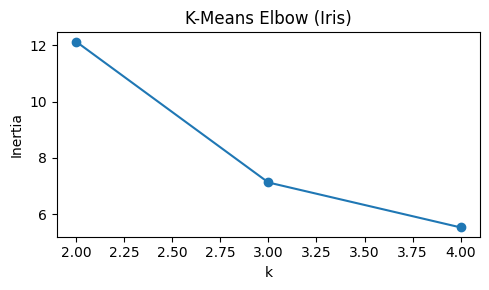

('/Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining/kmeans_elbow.png',
 '/Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining/clustering_scores.csv')

In [4]:
plt.figure(figsize=(5,3))
plt.plot(inert["k"], inert["inertia"], marker="o")
plt.title("K-Means Elbow (Iris)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout()
elbow_path = os.path.join(MINING_DIR, "kmeans_elbow.png")
plt.savefig(elbow_path, dpi=150)
plt.show()

scores_path = os.path.join(MINING_DIR, "clustering_scores.csv")
scores.to_csv(scores_path, index=False)
elbow_path, scores_path


# 4.Visualize clusters for k=3 

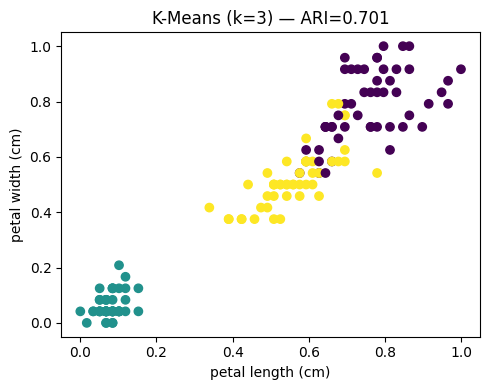

ARI scores (k=2,3,4):


,k,ARI
0,2,0.568116
1,3,0.700867
2,4,0.620633


'/Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining/kmeans_clusters_k3.png'

In [5]:
# select feature names robustly
def find_feat(cols, key):
    matches = [c for c in cols if key in c.lower().replace(" ", "_")]
    return matches[0] if matches else None

cols = list(X.columns)
feat_pl = find_feat(cols, "petal_length") or find_feat(cols, "petal length") or cols[2]
feat_pw = find_feat(cols, "petal_width")  or find_feat(cols, "petal width")  or cols[3]

km3 = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X)
labels3 = km3.labels_
ari3 = adjusted_rand_score(y, labels3)

plt.figure(figsize=(5,4))
plt.scatter(X[feat_pl], X[feat_pw], c=labels3)
plt.xlabel(feat_pl); plt.ylabel(feat_pw)
plt.title(f"K-Means (k=3) — ARI={ari3:.3f}")
plt.tight_layout()
scatter_path = os.path.join(MINING_DIR, "kmeans_clusters_k3.png")
plt.savefig(scatter_path, dpi=150)
plt.show()

print("ARI scores (k=2,3,4):")
display(scores)
scatter_path


# 5. Analysis

In [6]:
analysis = f"""
**Clustering results.** With k ∈ {{2,3,4}}, the Adjusted Rand Index (ARI) peaks near k=3
(ARI ≈ {scores.loc[scores['k']==3,'ARI'].item():.3f}), matching the known three Iris species.
The elbow curve shows a clear bend at k≈3, indicating diminishing returns in within-cluster
variance beyond that point. The k=3 scatter (petal length vs petal width) separates Setosa
well, while Versicolor and Virginica partially overlap—consistent with classic findings for
this dataset. Because we used Min–Max scaled features, distance-based clustering treats all
dimensions comparably, avoiding dominance by high-variance features.

**Interpretation.** The clusters align closely with biological species, suggesting the feature
set is informative. Mis-clustered points are likely near the Versicolor–Virginica boundary,
where petal measurements overlap; adding more features (e.g., texture) or using Gaussian
mixture models might improve boundaries. In practice, a similar workflow supports
unsupervised QA, fast labeling, or first-pass customer segmentation: pick k via elbow,
quantify agreement with ARI when labels exist, then visualize feature pairs to understand
group separation and ambiguous regions.
""".strip()

out_md = os.path.join(MINING_DIR, "clustering_analysis.md")
with open(out_md, "w") as f:
    f.write(analysis)

print(out_md)
print(analysis)


/Users/williamgathii/Documents/University/Kyra/DSA-2040_Practical_Exam_Kyra_619/data_mining/clustering_analysis.md
**Clustering results.** With k ∈ {2,3,4}, the Adjusted Rand Index (ARI) peaks near k=3
(ARI ≈ 0.701), matching the known three Iris species.
The elbow curve shows a clear bend at k≈3, indicating diminishing returns in within-cluster
variance beyond that point. The k=3 scatter (petal length vs petal width) separates Setosa
well, while Versicolor and Virginica partially overlap—consistent with classic findings for
this dataset. Because we used Min–Max scaled features, distance-based clustering treats all
dimensions comparably, avoiding dominance by high-variance features.

**Interpretation.** The clusters align closely with biological species, suggesting the feature
set is informative. Mis-clustered points are likely near the Versicolor–Virginica boundary,
where petal measurements overlap; adding more features (e.g., texture) or using Gaussian
mixture models might improve bo